In [3]:
import numpy as np
import pandas as pd
import nltk
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pickle

In [4]:
# Load the dataset
dataset = pd.read_csv('Reviews.csv')
dataset

,Rating,Comment
0,1.0 out of 5 stars,"I was loving my instant pot, bragging to all a..."
1,1.0 out of 5 stars,"Im not sure what happened here, because i know..."
2,5.0 out of 5 stars,I use this for everything! How did I live with...
3,1.0 out of 5 stars,This pot is designed to not work. The surface ...
4,5.0 out of 5 stars,I was chatting with a friend who just got a ni...
...,...,...
4995,1.0 out of 5 stars,I was so excited for it but the lid stinks fro...
4996,4.0 out of 5 stars,It takes almost as much time to bring it up to...
4997,5.0 out of 5 stars,I have a culinary degree and have worked in re...
4998,5.0 out of 5 stars,I've really enjoyed my instapot! Last night I ...


In [5]:
# Checking the contents of the dataset
dataset.rename(columns={'Rating': 'Ratings', 'Comment': 'Reviews'}, inplace=True)
print('\nDataset size:', dataset.shape)
print('\nColumns are:', dataset.columns)
print('\nDataset head:\n', dataset.head())


Dataset size: (5000, 2)

Columns are: Index(['Ratings', 'Reviews'], dtype='object')

Dataset head:
               Ratings                                            Reviews
0  1.0 out of 5 stars  I was loving my instant pot, bragging to all a...
1  1.0 out of 5 stars  Im not sure what happened here, because i know...
2  5.0 out of 5 stars  I use this for everything! How did I live with...
3  1.0 out of 5 stars  This pot is designed to not work. The surface ...
4  5.0 out of 5 stars  I was chatting with a friend who just got a ni...


In [6]:
dataset['polarity'] = [TextBlob(sentence).sentiment.polarity for sentence in dataset['Reviews']]
dataset['subjectivity'] = [TextBlob(sentence).sentiment.subjectivity for sentence in dataset['Reviews']]

In [7]:
dataset

,Ratings,Reviews,polarity,subjectivity
0,1.0 out of 5 stars,"I was loving my instant pot, bragging to all a...",0.056069,0.523551
1,1.0 out of 5 stars,"Im not sure what happened here, because i know...",0.087255,0.545915
2,5.0 out of 5 stars,I use this for everything! How did I live with...,0.364726,0.624685
3,1.0 out of 5 stars,This pot is designed to not work. The surface ...,-0.048437,0.567411
4,5.0 out of 5 stars,I was chatting with a friend who just got a ni...,0.085291,0.535627
...,...,...,...,...
4995,1.0 out of 5 stars,I was so excited for it but the lid stinks fro...,0.195000,0.503333
4996,4.0 out of 5 stars,It takes almost as much time to bring it up to...,0.100000,0.138462
4997,5.0 out of 5 stars,I have a culinary degree and have worked in re...,0.166667,0.504762
4998,5.0 out of 5 stars,I've really enjoyed my instapot! Last night I ...,0.016250,0.374167


In [8]:
# Removing extra content from the rating column and keeping only the relevant part - rating
print('Splitting the Ratings column to remove the extra content')
dataset[["Ratings", "out", "of", "5", "stars"]] = dataset["Ratings"].str.split(" ", expand = True)
print('Columns are:', dataset.columns)

dataset = dataset.drop(dataset.columns[[2, 3, 4, 5, 6, 7]], axis=1)
dataset['Ratings'] = pd.to_numeric(dataset['Ratings'])
print(dataset.head())
print('Dataset size:', dataset.shape)
print('Columns are:', dataset.columns)
print(dataset.info())

Splitting the Ratings column to remove the extra content
Columns are: Index(['Ratings', 'Reviews', 'polarity', 'subjectivity', 'out', 'of', '5',
       'stars'],
      dtype='object')
   Ratings                                            Reviews
0      1.0  I was loving my instant pot, bragging to all a...
1      1.0  Im not sure what happened here, because i know...
2      5.0  I use this for everything! How did I live with...
3      1.0  This pot is designed to not work. The surface ...
4      5.0  I was chatting with a friend who just got a ni...
Dataset size: (5000, 2)
Columns are: Index(['Ratings', 'Reviews'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ratings  5000 non-null   float64
 1   Reviews  5000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 78.2+ KB
None


In [9]:
# Converting all text to lowercase
print('Convert text to lower case')
dataset['Reviews'] = dataset['Reviews'].str.lower()
print(dataset.head())

Convert text to lower case
   Ratings                                            Reviews
0      1.0  i was loving my instant pot, bragging to all a...
1      1.0  im not sure what happened here, because i know...
2      5.0  i use this for everything! how did i live with...
3      1.0  this pot is designed to not work. the surface ...
4      5.0  i was chatting with a friend who just got a ni...


#### Removing the punctuation marks

In [10]:
print('Remove Punctuation')
print(string.punctuation)
def remove_punc(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

dataset['Reviews'] = dataset['Reviews'].apply(lambda x: remove_punc(x))
print(dataset.head())

Remove Punctuation
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
   Ratings                                            Reviews
0      1.0  i was loving my instant pot bragging to all ab...
1      1.0  im not sure what happened here because i know ...
2      5.0  i use this for everything how did i live witho...
3      1.0  this pot is designed to not work the surface a...
4      5.0  i was chatting with a friend who just got a ni...


#### Removing the numbers from the text

In [11]:
print('Removing Numbers from the text')
dataset['Reviews'] = dataset['Reviews'].str.replace('\d+', '')
print(dataset.head())

Removing Numbers from the text
   Ratings                                            Reviews
0      1.0  i was loving my instant pot bragging to all ab...
1      1.0  im not sure what happened here because i know ...
2      5.0  i use this for everything how did i live witho...
3      1.0  this pot is designed to not work the surface a...
4      5.0  i was chatting with a friend who just got a ni...


<ipython-input-11-7417b4075296>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['Reviews'] = dataset['Reviews'].str.replace('\d+', '')


#### Tokenizing the words (Separating words from a sentence)

In [12]:
print('Tokenization of words')
Reviews = dataset['Reviews']
dataset['Reviews'] = Reviews.apply(word_tokenize)
print(dataset.head())

Tokenization of words
   Ratings                                            Reviews
0      1.0  [i, was, loving, my, instant, pot, bragging, t...
1      1.0  [im, not, sure, what, happened, here, because,...
2      5.0  [i, use, this, for, everything, how, did, i, l...
3      1.0  [this, pot, is, designed, to, not, work, the, ...
4      5.0  [i, was, chatting, with, a, friend, who, just,...


#### Removing unnecessary words - stopwords

In [13]:
print('Removing stopwords')
stopword = nltk.corpus.stopwords.words('english')
print(stopword)

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

dataset['Reviews'] = dataset['Reviews'].apply(lambda x: remove_stopwords(x))
print(dataset.head())

Removing stopwords
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

#### Performing Stemming

In [14]:
print('Performing Stemming')
st = nltk.PorterStemmer()

def stemming(text):
    text = [st.stem(word) for word in text]
    return text

dataset['Reviews'] = dataset['Reviews'].apply(lambda x: stemming(x))
print(dataset.head())

Performing Stemming
   Ratings                                            Reviews
0      1.0  [love, instant, pot, brag, make, dog, food, ea...
1      1.0  [im, sure, happen, know, good, product, attemp...
2      5.0  [use, everyth, live, without, beforei, live, s...
3      1.0  [pot, design, work, surfac, area, pressur, ind...
4      5.0  [chat, friend, got, ninja, foodi, say, love, i...


##### Performing Lemmatization

##### observed that when I performed only lemmatization, the words did not get stemmed, hence implementing both

In [15]:
print('Performing Lemmatization')
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text


dataset['Reviews'] = dataset['Reviews'].apply(lambda x: lemmatizer(x))
print(dataset.head())

Performing Lemmatization
   Ratings                                            Reviews
0      1.0  [love, instant, pot, brag, make, dog, food, ea...
1      1.0  [im, sure, happen, know, good, product, attemp...
2      5.0  [use, everyth, live, without, beforei, live, s...
3      1.0  [pot, design, work, surfac, area, pressur, ind...
4      5.0  [chat, friend, got, ninja, foodi, say, love, i...


#### Forming a sentence from the remaining words

In [16]:
print('Joining the words to form a string/sentence')
corpus = []
print(dataset.shape)
data_length, _ = dataset.shape
for i in range(0, data_length):
    review = ' '.join(dataset['Reviews'][i])
    corpus.append(review)

print("Corpus", corpus)

Joining the words to form a string/sentence
(5000, 2)
Corpus ['love instant pot brag make dog food easi put food water press pressur cook like magic done beep get use pressur wasnt hard wasnt realli difficult useuntil last week pot didnt turn tri outlet electron outlet move pot differ outlet noth pot manual gave explicit troubleshoot direct base wrong turn meant circuit board blew advis call support call autom messag tell go onlin put ticket clearli compani doesnt want bother talk custom day later respons email ask help time email inform didnt hear friday need pot fix tuesday thursday though enough call amazon thank know treat custom abl refund product ship back pot le year purchas within warranti even amazon tri get ahold compani couldnt get responsebewar brand would look anoth pressur cooker break like wont get help daysmi first attempt post review amazon block unknown reason post though peopl know kind compani', 'im sure happen know good product attempt cook food first run minut lat

In [17]:
print(data_length)

5000


#### Classifying Reviews as positive/negative/neutral based on ratings

In [18]:
print("Classifying Reviews as positive/negative/neutral based on ratings")
classify = []
for i in range(0, data_length):
    if dataset['Ratings'][i] > 3.0: # Posiitve reviews
        classify.append(1)
    elif dataset['Ratings'][i] < 3.0: # Negative reviews
        classify.append(-1)
    else:
        classify.append(0) # Neutral reviews

Classifying Reviews as positive/negative/neutral based on ratings


In [19]:
print(dataset.head())

   Ratings                                            Reviews
0      1.0  [love, instant, pot, brag, make, dog, food, ea...
1      1.0  [im, sure, happen, know, good, product, attemp...
2      5.0  [use, everyth, live, without, beforei, live, s...
3      1.0  [pot, design, work, surfac, area, pressur, ind...
4      5.0  [chat, friend, got, ninja, foodi, say, love, i...


In [20]:
print(classify)
dataset['Classify'] = classify

[-1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 0, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 0, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 0, -1, -1, -1, 0, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 0, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 0, -1, -1, -1, -1, 1, 1, -1, -1, 0, -1, -1, 1, -1, 1, -1, 0, 1, -1, 1, 0, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 0, 1, -1, -1, -1, -1, -1, 0, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 0, 1, 0, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 0, -1, 0, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 0, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 0, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -

In [21]:
print(dataset.head())

   Ratings                                            Reviews  Classify
0      1.0  [love, instant, pot, brag, make, dog, food, ea...        -1
1      1.0  [im, sure, happen, know, good, product, attemp...        -1
2      5.0  [use, everyth, live, without, beforei, live, s...         1
3      1.0  [pot, design, work, surfac, area, pressur, ind...        -1
4      5.0  [chat, friend, got, ninja, foodi, say, love, i...         1


In [22]:
dataset

,Ratings,Reviews,Classify
0,1.0,"[love, instant, pot, brag, make, dog, food, ea...",-1
1,1.0,"[im, sure, happen, know, good, product, attemp...",-1
2,5.0,"[use, everyth, live, without, beforei, live, s...",1
3,1.0,"[pot, design, work, surfac, area, pressur, ind...",-1
4,5.0,"[chat, friend, got, ninja, foodi, say, love, i...",1
...,...,...,...
4995,1.0,"[excit, lid, stink, food, made, first, time, g...",-1
4996,4.0,"[take, almost, much, time, bring, pressur, wou...",1
4997,5.0,"[culinari, degre, work, restaur, year, normal,...",1
4998,5.0,"[ive, realli, enjoy, instapot, last, night, pu...",1


In [38]:
# Vectorizing the words and counting the frequency for each
# Extracting the features
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 2].values
# print(cv.vocabulary_)
print(X.shape)
print(y.shape)
print(data_length)

# Index is 60% of entire data
train_index = data_length * 3 // 5

# Index is between 60% and 90% of entire data 
test_index = train_index + (data_length - train_index) * 3 // 4

X_train = X[0 : train_index, :]
print("X_train: ", X_train)

X_test = X[train_index : test_index, :]
print("X_test: ", X_test)

X_val = X[test_index : data_length, :]
print("X_val", X_val)

y_train = y[0: train_index]
print("y_train", y_train)

y_test = y[train_index : test_index]
print("y_test", y_test)

y_val = y[test_index : data_length]
print("y_val", y_val)

(5000, 1500)
(5000,)
5000
X_train:  [[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
X_test:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
X_val [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
y_train [-1 -1  1 ...  1  1 -1]
y_test [1 1 0 ... 1 1 1]
y_val [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1  1
  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1
  1  0  1  0  1  1  1  1  1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1  0  1
 -1  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1 -1  1  1 -1 -1  1
  1  1  1  1  0  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  0  1  1  1
 -1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1

***************LOGISTIC REGRESSION*****************
[[ 119   14   40]
 [  27    5   43]
 [  52   25 1175]]
Accuracy from Logistic Regression classifier: 86.6
              precision    recall  f1-score   support

          -1       0.60      0.69      0.64       173
           0       0.11      0.07      0.08        75
           1       0.93      0.94      0.94      1252

    accuracy                           0.87      1500
   macro avg       0.55      0.56      0.55      1500
weighted avg       0.85      0.87      0.86      1500



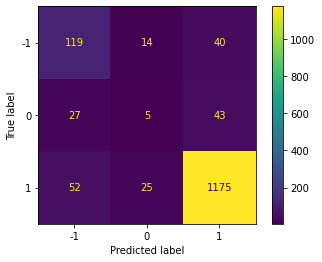

In [39]:
print("***************LOGISTIC REGRESSION*****************")
lr = LogisticRegression(max_iter=data_length) # Keeping it 5000 as there are 5000 rows
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr, labels=lr.classes_)
print(cm)
acc_lr = accuracy_score(y_test, y_pred_lr)*100
print('Accuracy from Logistic Regression classifier:', acc_lr)
print(classification_report(y_test, y_pred_lr))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.show()

***************XGBOOST*****************


c:\users\sebel\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 120    3   50]
 [  24    4   47]
 [  36    3 1213]]
Accuracy from XGBoost: 89.13333333333333
              precision    recall  f1-score   support

          -1       0.67      0.69      0.68       173
           0       0.40      0.05      0.09        75
           1       0.93      0.97      0.95      1252

    accuracy                           0.89      1500
   macro avg       0.66      0.57      0.57      1500
weighted avg       0.87      0.89      0.87      1500



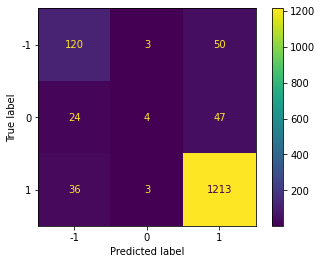

In [40]:
print("***************XGBOOST*****************")

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xg = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xg, labels=xgb.classes_)
print(cm)
acc_xgb = accuracy_score(y_test, y_pred_xg)*100
print('Accuracy from XGBoost:', acc_xgb)
print(classification_report(y_test, y_pred_xg))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
plt.show()

***************RANDOM FOREST CLASSIFIER*****************
[[ 107    0   66]
 [  21    0   54]
 [  23    0 1229]]
Accuracy from RandomForestClassifier: 89.06666666666668


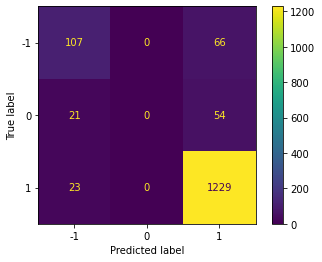

In [41]:
print("***************RANDOM FOREST CLASSIFIER*****************")

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
print(cm)
acc_rf = accuracy_score(y_test, y_pred_rf)*100
print('Accuracy from RandomForestClassifier:', acc_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

***************K-NEAREST NEIGHBOURS*****************
For 1 Neighbours, error is: 0.7366666666666667
For 2 Neighbours, error is: 0.6093333333333333
For 3 Neighbours, error is: 0.77
For 4 Neighbours, error is: 0.772
For 5 Neighbours, error is: 0.8206666666666667
For 6 Neighbours, error is: 0.8173333333333334
For 7 Neighbours, error is: 0.832
For 8 Neighbours, error is: 0.8346666666666667
For 9 Neighbours, error is: 0.8393333333333334
For 10 Neighbours, error is: 0.842
Minimum error is for 2 Neighbours
[[121   4  48]
 [ 51   2  22]
 [407  54 791]]
Accuracy from KNN: 60.93333333333333
              precision    recall  f1-score   support

          -1       0.21      0.70      0.32       173
           0       0.03      0.03      0.03        75
           1       0.92      0.63      0.75      1252

    accuracy                           0.61      1500
   macro avg       0.39      0.45      0.37      1500
weighted avg       0.79      0.61      0.66      1500



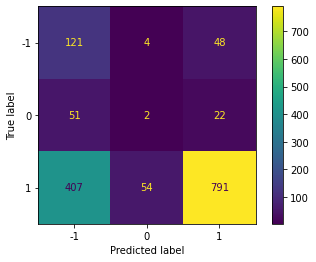

In [42]:
print("***************K-NEAREST NEIGHBOURS*****************")
# from sklearn.model_selection import GridSearchCV
# # Incase  of classifier like  knn the parameter to be tuned is n_neighbors
# param_grid = {'n_neighbors': np.arange(1, 10)}
# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, param_grid, cv=5)
# print(knn_cv.fit(X_train, y_train))
# print(knn_cv.best_score_*100)
# i = knn_cv.best_params_
# print("i = " + str(i))
# # try to find best k value
error = []

for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    err = knn.score(X_test, y_test)
    error.append(err)
    print("For " + str(i) + " Neighbours, error is: " + str(err))

i = error.index(min(error))
i += 1
print("Minimum error is for " + str(i) + " Neighbours")

classifier = KNeighborsClassifier(n_neighbors = i)
classifier.fit(X_train,y_train)
y_pred_knn = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred_knn, labels=classifier.classes_)
print(cm)
acc_knn = accuracy_score(y_test, y_pred_knn)*100
print('Accuracy from KNN:', acc_knn)
print(classification_report(y_test, y_pred_knn))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

***************MULTINOMIAL NAIVE BAYESIAN CLASSIFIER*****************
[[ 132    6   35]
 [  30    7   38]
 [  51   20 1181]]
Accuracy from Naive Bayes: 88.0
              precision    recall  f1-score   support

          -1       0.62      0.76      0.68       173
           0       0.21      0.09      0.13        75
           1       0.94      0.94      0.94      1252

    accuracy                           0.88      1500
   macro avg       0.59      0.60      0.59      1500
weighted avg       0.87      0.88      0.87      1500



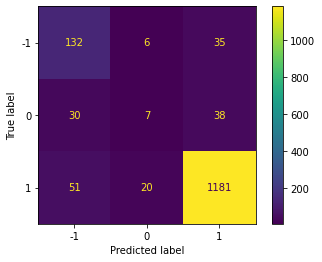

In [43]:
print("***************MULTINOMIAL NAIVE BAYESIAN CLASSIFIER*****************")

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_mnb, labels=mnb.classes_)
print(cm)
acc_mnb = accuracy_score(y_test, y_pred_mnb)*100
print('Accuracy from Naive Bayes:', acc_mnb)
print(classification_report(y_test, y_pred_mnb))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb.classes_)
disp.plot()
plt.show()

***********ACCURACY SCORE FOR TESTING SET***************
                                Model  Testing Accuracy %
0  Multinomial Naive Bayes Classifier           88.000000
1                 K Nearest Neighbour           60.933333
2            Random Forest Classifier           89.066667
3                             XGBoost           89.133333
4                 Logistic Regression           86.600000


<AxesSubplot:>

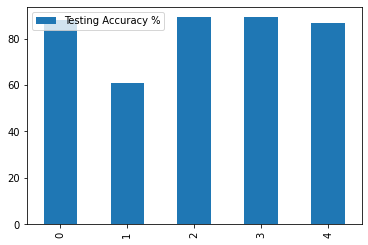

In [44]:
print("***********ACCURACY SCORE FOR TESTING SET***************")

table_lr = pd.DataFrame(data=[["Logistic Regression", acc_lr]], columns=['Model', 'Testing Accuracy %'])

table_xgb = pd.DataFrame(data=[["XGBoost", acc_xgb]], columns=['Model', 'Testing Accuracy %'])
table_xgb = table_xgb.append(table_lr, ignore_index=True)

table_rf = pd.DataFrame(data=[["Random Forest Classifier", acc_rf]], columns=['Model', 'Testing Accuracy %'])
table_rf = table_rf.append(table_xgb, ignore_index=True)

table_knn = pd.DataFrame(data=[["K Nearest Neighbour", acc_knn]], columns=['Model', 'Testing Accuracy %'])
table_knn = table_knn.append(table_rf, ignore_index=True)

table_mnb = pd.DataFrame(data=[["Multinomial Naive Bayes Classifier", acc_mnb]], columns=['Model', 'Testing Accuracy %'])
table_mnb = table_mnb.append(table_knn, ignore_index=True)


print(table_mnb)
table_mnb.plot.bar()

In [45]:
print("********************VALIDATION SET********************")
print("Calculating accuracy scores for validation set......")
val_lr = lr.predict(X_val)
val_xgb = xgb.predict(X_val)
val_rf = rf.predict(X_val)
val_knn = knn.predict(X_val)
val_mnb = mnb.predict(X_val)


accuracy_lr = accuracy_score(y_val, val_lr)*100
accuracy_xgb = accuracy_score(y_val, val_xgb)*100
accuracy_rf = accuracy_score(y_val, val_rf)*100
accuracy_knn = accuracy_score(y_val, val_knn)*100
accuracy_mnb = accuracy_score(y_val, val_mnb)*100

********************VALIDATION SET********************
Calculating accuracy scores for validation set......


***********ACCURACY SCORE FOR VALIDATION SET***************
                                Model  Testing Accuracy %
0  Multinomial Naive Bayes Classifier                89.6
1                 K Nearest Neighbour                82.4
2            Random Forest Classifier                87.6
3                             XGBoost                88.0
4                 Logistic Regression                87.0


<AxesSubplot:>

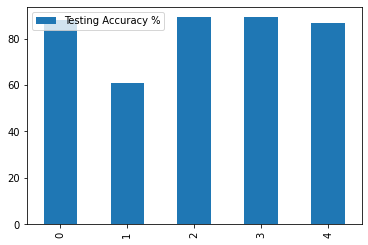

In [46]:
print("***********ACCURACY SCORE FOR VALIDATION SET***************")

tLR = pd.DataFrame(data=[["Logistic Regression", accuracy_lr]], columns=['Model', 'Testing Accuracy %'])

tXGB = pd.DataFrame(data=[["XGBoost", accuracy_xgb]], columns=['Model', 'Testing Accuracy %'])
tXGB = tXGB.append(tLR, ignore_index=True)

tRF = pd.DataFrame(data=[["Random Forest Classifier", accuracy_rf]], columns=['Model', 'Testing Accuracy %'])
tRF = tRF.append(tXGB, ignore_index=True)

tKNN = pd.DataFrame(data=[["K Nearest Neighbour", accuracy_knn]], columns=['Model', 'Testing Accuracy %'])
tKNN = tKNN.append(tRF, ignore_index=True)

tMNB = pd.DataFrame(data=[["Multinomial Naive Bayes Classifier", accuracy_mnb]], columns=['Model', 'Testing Accuracy %'])
tMNB = tMNB.append(tKNN, ignore_index=True)

print(tMNB)
table_mnb.plot.bar()

#### Save the model that was most effective (MULTINOMIAL NAIVE BAYESIAN CLASSIFIER)

In [47]:
file = open('my_classifier.pickle', 'wb')


pickle.dump((mnb, cv), file)

file.close()